In [1]:
import numpy as np
from dataclasses import dataclass
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

In [ ]:
#set up ode for optimization
def lotka_volterra(du, u, p, t):  
    x, y = u,
    a, b, c, d = p 
    du[1] = dx = a*x - b*x*y
    du[2] = dy = -c*y + d*x*y
    return[du[1], du[2]]

u0 = [1.0, 1.0] #initlal values
t_span = [0.0, 40.0] #time span
t_eval = np.linspace(t_span[0],t_span[1])
p = np.array([1.0, 0.1, 1.5, 0.075])
solution = solve_ivp(lotka_volterra, t_span, u0, p)








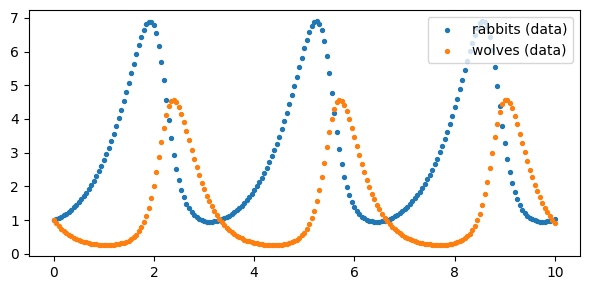

iter    1 | loss=134.525795 | params=[ 3.9   1.1   1.9   0.5  -0.05]


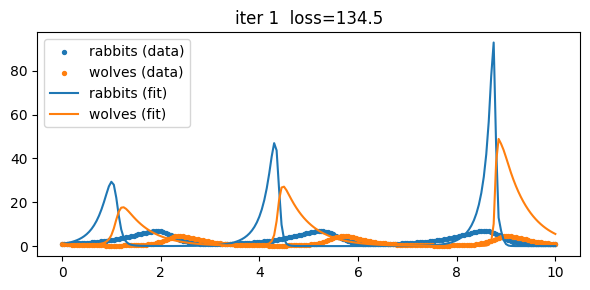

iter  200 | loss=2.573391 | params=[ 3.54022843  1.47292885  2.26200106  0.78438619 -0.54677926]


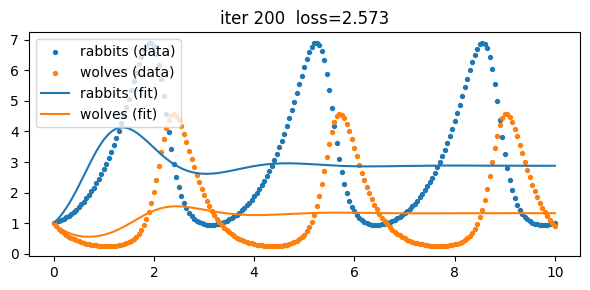

iter  400 | loss=2.457586 | params=[ 3.33176391  1.18082167  2.22201769  0.75409213 -0.50079335]


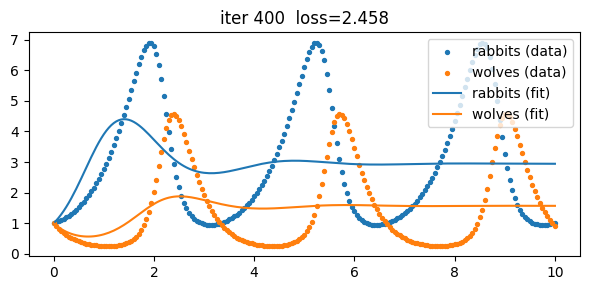

iter  600 | loss=2.298298 | params=[ 2.91773307  1.00273249  2.23737895  0.76306374 -0.40484207]


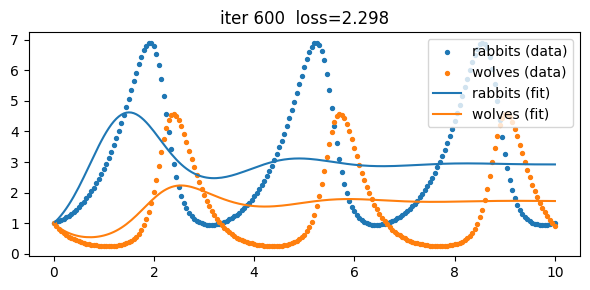

iter  800 | loss=0.832453 | params=[ 1.91122489  0.84708525  2.35875696  0.77615344 -0.09606801]


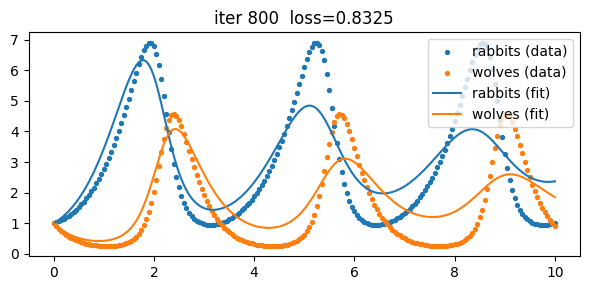

iter 1000 | loss=0.012712 | params=[ 1.60878555e+00  1.06726463e+00  2.71906831e+00  8.96660854e-01
 -1.29563411e-03]


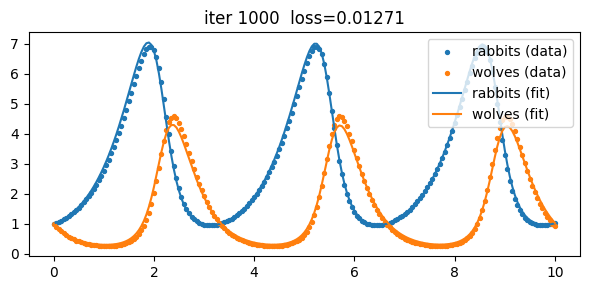


True params   :  [1.5 1.  3.  1.  0. ]
Recovered par.:  [ 1.60878555e+00  1.06726463e+00  2.71906831e+00  8.96660854e-01
 -1.29563411e-03]


In [4]:
# lotka_volterra_fit.py
# Python recreation of the Julia DiffEqFlux example (no external ODE libs required)

import math, torch
import matplotlib.pyplot as plt

# ----------------------------
# 1) Problem setup (mirrors Julia)
# ----------------------------
device = "cpu"
dtype  = torch.float64  # better numerical stability

# ODE: du/dt = f(u, p, t)
def f(u, p, t):
    x, y = u[..., 0], u[..., 1]
    alpha, beta, delta, gamma, famma = p
    dx = alpha * x - beta * x * y + famma * x * x
    dy = -delta * y + gamma * x * y
    return torch.stack([dx, dy], dim=-1)

# Simple differentiable RK4 step in torch
# RK4 averages four different slope estimates to get much higher accuracy.
def rk4_step(u, p, t, h):
    k1 = f(u, p, t) #start of interval
    k2 = f(u + 0.5*h*k1, p, t + 0.5*h) # midway through interval 
    k3 = f(u + 0.5*h*k2, p, t + 0.5*h) # better midway apporximation
    k4 = f(u + h*k3,     p, t + h) # end of interval 
    return u + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4) # combine slopes weighted avge

# Integrate over a time grid, returning the full trajectory (saveat)
def solve_ode(u0, p, t0, t1, dt):
    steps = int(round((t1 - t0)/dt))
    ts = torch.linspace(t0, t1, steps + 1, dtype=dtype, device=device)
    us = torch.empty((steps + 1, 2), dtype=dtype, device=device)
    u = u0.clone()
    us[0] = u
    t = t0
    for i in range(steps):
        u = rk4_step(u, p, t, dt)
        t += dt
        us[i+1] = u
    return ts, us

# ----------------------------
# 2) Generate synthetic data (Julia's "Verify ODE" + "Generate data")
# ----------------------------
u0_true = torch.tensor([1.0, 1.0], dtype=dtype, device=device)
tspan = (0.0, 10.0)
saveat = 0.05

p_true = torch.tensor([1.5, 1.0, 3.0, 1.0, 0.0], dtype=dtype, device=device)  # α β δ γ (Julia order)
t_data, u_data = solve_ode(u0_true, p_true, tspan[0], tspan[1], saveat)
A1 = u_data[:, 0]  # rabbits
A2 = u_data[:, 1]  # wolves

# (Optional) show the generated data
plt.figure(figsize=(6,3))
plt.scatter(t_data.cpu(), A1.cpu(), s=8, label="rabbits (data)")
plt.scatter(t_data.cpu(), A2.cpu(), s=8, label="wolves (data)")
plt.legend(); plt.tight_layout(); plt.show()

# ----------------------------
# 3) Parameter learning (mirrors Julia’s ADAM loop & callback plotting)
# ----------------------------
# Initial guess (matches your Julia: param([4., 1., 2., 0.4]))
p = torch.nn.Parameter(torch.tensor([4.0, 1.0, 2.0, 0.4, 0.05], dtype=dtype, device=device))

optimizer = torch.optim.Adam([p], lr=1e-1)
u0 = u0_true.detach()  # same initial condition used during fitting

# Training loop with a live callback-like plot every N iters
num_iters = 1000
plot_every = 200

for it in range(1, num_iters + 1):
    optimizer.zero_grad()
    _, u_pred = solve_ode(u0, p, tspan[0], tspan[1], saveat)
    loss = torch.mean((u_pred - u_data)**2)  # like sum(abs2, predict - data) scaled
    loss.backward()
    optimizer.step()

    if it % plot_every == 0 or it == 1 or it == num_iters:
        with torch.no_grad():
            print(f"iter {it:4d} | loss={loss.item():.6f} | params={p.data.cpu().numpy()}")
            plt.figure(figsize=(6,3))
            plt.scatter(t_data.cpu(), A1.cpu(), s=8, label="rabbits (data)")
            plt.scatter(t_data.cpu(), A2.cpu(), s=8, label="wolves (data)")
            plt.plot(t_data.cpu(), u_pred[:,0].cpu(), label="rabbits (fit)")
            plt.plot(t_data.cpu(), u_pred[:,1].cpu(), label="wolves (fit)")
            plt.title(f"iter {it}  loss={loss.item():.4g}")
            plt.legend(); plt.tight_layout(); plt.show()

print("\nTrue params   : ", p_true.cpu().numpy())
print("Recovered par.: ", p.detach().cpu().numpy())


WHAT HAVE I LEARNED
there are a few things we can look out for to try to gv ourselves more room to have a worse intial value guess
1)  we can decrease the value of dt. dt is what we use to get a better estimate of out slope by inducing more frequent samples in our RTK sample
    HOWEVER smaller dt -> better compase not necessarily better conversion -> we need to increase the run time to allow for improved conversion time
2)  more run time = better conversion at the expense of compute
3)  we need to be careful of terms that "BLOW UP" the ode fast. big terms that go to inifinity -> when computing the loss we get infinity/Nan -> when computing the gradient we get Nan/infinty -> optimization doesn't work. 
To conteract this we need a better inital value guess(closer to the actual value), increaase run time, maybe introduce clips to avoid explosion, lower dt value (could be dangerous as we could be swaying our algorithm towards noise) , lower learning rate(lr) for more accurate gradient descent

In [ ]:
# adaptive_therapy_fit_and_control.py
# PyTorch-only, differentiable ODE (RK4), parameter fitting + control optimization

import math, torch
from torch import nn
torch.set_default_dtype(torch.float64)
DEVICE = "cpu"

# ------------------------------------------------------------
# 1) Model structure (states, controls, parameters)
# ------------------------------------------------------------
# States x = [T, E, Ki67, ESR1m, PI3K, ctDNA, C_chemo, I_immuno]
IDX = {
    "T":0, "E":1, "Ki67":2, "ESR1m":3, "PI3K":4, "ctDNA":5, "C":6, "I":7
}

def positive(x):  # softplus with small epsilon to ensure strictly positive
    return torch.nn.functional.softplus(x, beta=1.0) + 1e-8

class PatientParams(nn.Module):
    """
    Unconstrained parameters -> constrained via softplus/exp so gradients are stable.
    Grouped into: fit_from_data (learnable), fixed_from_lit (frozen).
    """
    def __init__(self):
        super().__init__()
        # ---- Learnable (patient-specific) ----
        # tumor kinetics
        #nn.parameter - marks the parameter for gradient computation and gives the parameter the abiligty to be updated
        self._rT      = nn.Parameter(torch.log(torch.tensor(0.04)))   # /day
        self._KT      = nn.Parameter(torch.log(torch.tensor(1.0)))    # normalized capacity
        # drug & immune effects
        self._k_chemo = nn.Parameter(torch.log(torch.tensor(0.30)))
        self._k_imm   = nn.Parameter(torch.log(torch.tensor(0.05)))
        # immune kinetics
        self._rE      = nn.Parameter(torch.log(torch.tensor(0.10)))
        self._KE      = nn.Parameter(torch.log(torch.tensor(1.0)))
        self._alpha   = nn.Parameter(torch.log(torch.tensor(0.40)))   # stim by I
        self._beta    = nn.Parameter(torch.log(torch.tensor(0.05)))   # exhaustion
        # biomarker couplings
        self._p_ct    = nn.Parameter(torch.log(torch.tensor(0.25)))   # ctDNA shedding ~ T
        self._k_ctclr = nn.Parameter(torch.log(torch.tensor(0.20)))   # ctDNA clearance
        # resistance / pathway drift (slow)
        self._r_ESR1m = nn.Parameter(torch.log(torch.tensor(0.003)))
        self._r_PI3K  = nn.Parameter(torch.log(torch.tensor(0.002)))

        # ---- Fixed (literature / protocol); can unfreeze later ----
        self._lambdaC = nn.Parameter(torch.log(torch.tensor(0.20)), requires_grad=False)  # chemo clearance
        self._lambdaI = nn.Parameter(torch.log(torch.tensor(0.10)), requires_grad=False)  # immuno clearance

    def constrained(self):
        return {
            "rT"     : positive(self._rT.exp()),
            "KT"     : positive(self._KT.exp()),
            "k_chemo": positive(self._k_chemo.exp()),
            "k_imm"  : positive(self._k_imm.exp()),
            "rE"     : positive(self._rE.exp()),
            "KE"     : positive(self._KE.exp()),
            "alpha"  : positive(self._alpha.exp()),
            "beta"   : positive(self._beta.exp()),
            "p_ct"   : positive(self._p_ct.exp()),
            "k_ctclr": positive(self._k_ctclr.exp()),
            "r_ESR1m": positive(self._r_ESR1m.exp()),
            "r_PI3K" : positive(self._r_PI3K.exp()),
            "lambdaC": positive(self._lambdaC.exp()),
            "lambdaI": positive(self._lambdaI.exp()),
        }

# ------------------------------------------------------------
# 2) Controls u(t): piecewise constant dosing over a grid
# ------------------------------------------------------------
class PiecewiseConstantDosing(nn.Module):
    """
    u_chemo[k], u_immuno[k] are the dose inputs applied during [t_k, t_{k+1}).
    Learnable, nonnegative via softplus.
    """
    def __init__(self, n_steps, init_chemo=0.0, init_immuno=0.0, learnable=True):
        super().__init__()
        self.learnable = learnable
        if learnable:
            self._u_c = nn.Parameter(torch.full((n_steps,), math.log(max(init_chemo,1e-6)))) 
            # creates a tensor of size n_steps then fills it with the log of the value of init_chemo or log (1e-6) depending on which is larger between the two
            self._u_i = nn.Parameter(torch.full((n_steps,), math.log(max(init_immuno,1e-6))))
        else:
            self.register_buffer("_u_c", torch.full((n_steps,), math.log(max(init_chemo,1e-6)))) #register_buffer makes the parameter not learnable
            self.register_buffer("_u_i", torch.full((n_steps,), math.log(max(init_immuno,1e-6))))

    def controls(self):
        # softplus(exp(logu)) ~ positive
        return positive(self._u_c.exp()), positive(self._u_i.exp())

    def value_at_index(self, idx):
        u_c, u_i = self.controls()
        return torch.stack([u_c[idx], u_i[idx]], dim=0)  # [2,] gets the immuno and chemo dose at time step idx
    @torch.no_grad()
    def set_protocol(self, uC_values, uI_values):
        """
        uC_values, uI_values: 1D arrays/iterables (len == n_steps), nonnegative.
        Write directly into the *raw* internal buffers so future controls() reflects them.
        """
        uC_values = torch.as_tensor(uC_values, dtype=torch.float64, device=self._u_c.device)
        uI_values = torch.as_tensor(uI_values, dtype=torch.float64, device=self._u_i.device)
        eps = 1e-8
        # Store in log-space; controls() later maps: positive(exp(logv))
        self._u_c.data = torch.log(torch.clamp(uC_values, min=eps))
        self._u_i.data = torch.log(torch.clamp(uI_values, min=eps))

# ------------------------------------------------------------
# 3) ODE right-hand side and RK4 integrator
# ------------------------------------------------------------
def rhs(x, params, u_vec):
    """
    x: (..., 8) state
    u_vec: (2,) controls for this time slice: [u_chemo, u_immuno]
    returns dx/dt
    """
    T = x[..., IDX["T"]]
    E = x[..., IDX["E"]]
    Ki = x[..., IDX["Ki67"]]
    ESR1m = x[..., IDX["ESR1m"]]
    PI3K  = x[..., IDX["PI3K"]]
    ct    = x[..., IDX["ctDNA"]]
    C     = x[..., IDX["C"]]
    I     = x[..., IDX["I"]]

    rT, KT = params["rT"], params["KT"]
    kC, kImm = params["k_chemo"], params["k_imm"]
    rE, KE, alpha, beta = params["rE"], params["KE"], params["alpha"], params["beta"]
    p_ct, k_ctclr = params["p_ct"], params["k_ctclr"]
    r_ESR1m, r_PI3K = params["r_ESR1m"], params["r_PI3K"]
    lamC, lamI = params["lambdaC"], params["lambdaI"]

    # Tumor: logistic growth - chemo kill - immune kill
    dT = rT*T*(1.0 - T/KT) - kC*C*T - kImm*E*T
    # Immune: logistic + stimulation by I - exhaustion
    dE = rE*E*(1.0 - E/KE) + alpha*I - beta*E
    # Proliferation index (toy: attracted to growth, damped by chemo exposure)
    dKi = 0.5*(rT - kC*C)*torch.clamp(1.0 - Ki,0.,1.) - 0.2*Ki
    # Resistance / pathways (slow drift upward, could couple to C,E later)
    dESR1m = r_ESR1m*(1.0 - ESR1m)
    dPI3K  = r_PI3K*(1.0 - PI3K)
    # ctDNA: shed proportional to T; first-order clearance
    dct = p_ct*T - k_ctclr*ct
    # PK compartments with exogenous inputs u_vec
    uC, uI = u_vec[0], u_vec[1]
    dC = -lamC*C + uC
    dI = -lamI*I + uI

    dx = torch.stack([dT, dE, dKi, dESR1m, dPI3K, dct, dC, dI], dim=-1)
    # clamp bounded states via reflected gradient trick (optional light-touch)
    return dx
def rk4(f, x0, params, dosing: PiecewiseConstantDosing, tgrid, substeps=1):
    """
    f: rhs function
    x0: (8,) initial state
    tgrid: (N+1,) times; we step between indices
    dosing: piecewise controls aligned with intervals [t_k, t_{k+1})
    substeps: internal fixed substepping per interval
    """
    x = x0  # keep graph; no in-place edits below
    traj = [x0]

    # Prebuild bound vectors on the right device/dtype
    
    mins = torch.tensor([0., 0., 0., 0., 0., 0., 0., 0.],
                        dtype=x0.dtype, device=x0.device)
    maxs = torch.tensor([
        float('inf'),  # T  (lower-bounded only)
        float('inf'),  # E  (lower-bounded only)
        1.0,           # Ki67  in [0,1]
        1.0,           # ESR1m in [0,1]
        1.0,           # PI3K  in [0,1]
        float('inf'),  # ctDNA (lower-bounded only)
        float('inf'),  # C
        float('inf')   # I
    ], dtype=x0.dtype, device=x0.device)

    for k in range(len(tgrid) - 1):
        dt_full = tgrid[k+1] - tgrid[k]
        dt = dt_full / substeps

        for _ in range(substeps):
            u_vec = dosing.value_at_index(k) #gets dosing values at timestep

            k1 = f(x, params, u_vec)
            k2 = f(x + 0.5 * dt * k1, params, u_vec)
            k3 = f(x + 0.5 * dt * k2, params, u_vec)
            k4 = f(x + dt * k3, params, u_vec)

            x_next = x + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

            # Non-inplace bounding via elementwise min/max
            x_next = torch.maximum(x_next, mins)
            x_next = torch.minimum(x_next, maxs)
            #makes sure we stay biologicially accurate 

            x = x_next

        traj.append(x)

    return torch.stack(traj, dim=0)  # (N+1, 8)

# ------------------------------------------------------------
# 4) Losses (data-fitting and control objective)
# ------------------------------------------------------------
def mse_mask(pred, obs):
    """obs can contain NaNs for missing measurements; they are ignored."""
    mask = ~torch.isnan(obs) #finds non-Nan zero entries 
    if mask.sum() == 0:
        return torch.tensor(0.0, dtype=pred.dtype, device=pred.device)
    return ((pred[mask]-obs[mask])**2).mean() #take mean of mse to scale 

def fitting_loss(traj, tgrid, obs_dict):
    """
    obs_dict: {
        "T": (times_idx_tensor, values_tensor),
        "ctDNA": (...), "E": (...), "Ki67": (...), etc.  Values can have NaNs.
    }
    """"
    #this assumes that i have real data about the patient at each time step which isn't correct
    #I think this is where lenia comes in because I would need the trajectories
    loss = torch.tensor(0.0, dtype=traj.dtype, device=traj.device)
    for key, (idxs, vals) in obs_dict.items():
        comp = traj[idxs, IDX[key]]
        loss = loss + mse_mask(comp, vals)
    return loss #adds losses for all terms in IDX (T,E, ki67,...)

def control_objective(traj, dosing: PiecewiseConstantDosing, w_tumor=1.0, w_toxic=0.2, w_dose=0.01): #weights for importance
    #right now minimizing tumor soze is most important
    # can extend this equation to include more 'goals'
    """
    Example objective: final tumor + toxicity proxy + L2 on doses.
    Toxicity proxy = low immune nadir + cumulative ctDNA spike (illustrative).
    """
    T_final = traj[-1, IDX["T"]] #final value of tumor 
    E_min   = torch.clamp(traj[:, IDX["E"]].min(), 0., None)  # higher is better; penalize low via (target - E_min)+
    #finds the lowest state for the immune system, low = bad
    tox_proxy = torch.clamp(0.5 - E_min, min=0.0) # if immune systems < 0.5 then we penalize toxicity
    uC, uI = dosing.controls()
    dose_pen = (uC.pow(2).mean() + uI.pow(2).mean()) # This is an L2 regularization term — it keeps the optimizer from choosing unrealistically large doses.

    return w_tumor*T_final + w_toxic*tox_proxy + w_dose*dose_pen

# ------------------------------------------------------------
# 5) Synthetic data helper (for demo)
# ------------------------------------------------------------
def make_synthetic_data(true_params, tgrid, true_dosing, x0, noise=0.03):
    with torch.no_grad():
        traj = rk4(rhs, x0, true_params, true_dosing, tgrid, substeps=2)
        # pick a few observable channels
        idxs = torch.arange(0, len(tgrid), 3, device=traj.device)  # measure every 3 steps
        obs = {
            "T": (idxs, traj[idxs, IDX["T"]] * (1 + noise*torch.randn_like(idxs, dtype=traj.dtype))),
            "ctDNA": (idxs, traj[idxs, IDX["ctDNA"]] * (1 + noise*torch.randn_like(idxs, dtype=traj.dtype))),
            "E": (idxs, traj[idxs, IDX["E"]] * (1 + noise*torch.randn_like(idxs, dtype=traj.dtype))),
        }
        return obs, traj

# ------------------------------------------------------------
# 6) End-to-end: fit θ, then optimize u(t)
# ------------------------------------------------------------
def fit_patient_params(tgrid, x0, dosing, initial_params: PatientParams, obs_dict,
                       steps_adam=400, steps_lbfgs=80, lr=0.08):
    model = initial_params
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for it in range(steps_adam):
        opt.zero_grad()
        params = model.constrained()
        traj = rk4(rhs, x0, params, dosing, tgrid, substeps=2)
        loss = fitting_loss(traj, tgrid, obs_dict)
        loss.backward()
        opt.step()
    # polish with LBFGS (optional)
    def closure():
        opt_lbfgs.zero_grad()
        params = model.constrained()
        traj = rk4(rhs, x0, params, dosing, tgrid, substeps=2)
        loss = fitting_loss(traj, tgrid, obs_dict)
        loss.backward()
        return loss
    opt_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=steps_lbfgs, line_search_fn="strong_wolfe")
    opt_lbfgs.step(closure)
    # final forward
    with torch.no_grad():
        params = model.constrained()
        traj = rk4(rhs, x0, params, dosing, tgrid, substeps=2)
        loss = fitting_loss(traj, tgrid, obs_dict).item()
    return model, traj, loss

def optimize_dosing_given_patient(tgrid, x0, fitted_params: PatientParams,
                                  n_steps, init_chemo=0.0, init_immuno=0.0,
                                  steps=600, lr=0.05):
    dosing = PiecewiseConstantDosing(n_steps, init_chemo, init_immuno, learnable=True)
    opt = torch.optim.Adam(dosing.parameters(), lr=lr)
    best = math.inf
    best_u = None
    for it in range(steps):
        opt.zero_grad()
        params = fitted_params.constrained()
        traj = rk4(rhs, x0, params, dosing, tgrid, substeps=2)
        J = control_objective(traj, dosing, w_tumor=1.0, w_toxic=0.3, w_dose=0.01)
        J.backward()
        opt.step()
        if J.item() < best:
            best = J.item()
            with torch.no_grad():
                best_u = [p.detach().clone() for p in dosing.parameters()]
    # load best
    if best_u is not None:
        with torch.no_grad():
            for p, b in zip(dosing.parameters(), best_u):
                p.copy_(b)
    return dosing

# ------------------------------------------------------------
# 7) Demo / Replace this block with your real patient data
# ------------------------------------------------------------
if __name__ == "__main__":
    torch.manual_seed(7)

    # Time grid (e.g., 60 days, daily steps)
    N_DAYS = 60
    tgrid = torch.linspace(0., float(N_DAYS), N_DAYS+1, device=DEVICE)

    # Initial state (replace T0/E0/etc. with patient baseline if you have it)
    x0 = torch.zeros(8, dtype=torch.float64, device=DEVICE)
    x0[IDX["T"]] = 0.15      # normalized tumor burden
    x0[IDX["E"]] = 0.30      # immune effector level
    x0[IDX["Ki67"]] = 0.40
    x0[IDX["ESR1m"]] = 0.05
    x0[IDX["PI3K"]] = 0.10
    x0[IDX["ctDNA"]] = 0.02
    x0[IDX["C"]] = 0.0
    x0[IDX["I"]] = 0.0

true_params = PatientParams().constrained()

true_dosing = PiecewiseConstantDosing(n_steps=N_DAYS, learnable=False)
uC_vals = torch.zeros(N_DAYS, dtype=torch.float64, device=DEVICE)
uI_vals = torch.full((N_DAYS,), 0.02, dtype=torch.float64, device=DEVICE)
for d in [5, 12, 19, 26]:
    uC_vals[d] = 0.6
true_dosing.set_protocol(uC_vals, uI_vals)

# Generate synthetic observations (T, ctDNA, E) measured every 3 days
OBS_DICT, true_traj = make_synthetic_data(true_params, tgrid, true_dosing, x0, noise=0.05)

# -------------------
# FIT PATIENT PARAMS
# -------------------
init_params = PatientParams().to(DEVICE)

known_protocol = PiecewiseConstantDosing(n_steps=N_DAYS, learnable=False)
known_protocol.set_protocol(uC_vals, uI_vals)   # <-- this is all you need

fitted_params, fit_traj, fit_loss = fit_patient_params(
    tgrid, x0, known_protocol, init_params, OBS_DICT,
    steps_adam=400, steps_lbfgs=60, lr=0.08
)
print(f"[Fit] data-fit loss = {fit_loss:.6f}")

    # --------------------------------------------
    # OPTIMIZE A NEW DOSING SCHEDULE FOR THIS PATIENT
    # --------------------------------------------
dosing_opt = optimize_dosing_given_patient(
        tgrid, x0, fitted_params, n_steps=N_DAYS, init_chemo=0.0, init_immuno=0.01,
        steps=500, lr=0.05
    )
with torch.no_grad():
        params = fitted_params.constrained()
        traj_opt = rk4(rhs, x0, params, dosing_opt, tgrid, substeps=2)
        J = control_objective(traj_opt, dosing_opt).item()
        print(f"[Control] objective after optimization = {J:.6f}")

        uC_opt, uI_opt = dosing_opt.controls()
        print(f"[Control] mean chemo dose: {uC_opt.mean().item():.4f}, max chemo pulse: {uC_opt.max().item():.4f}")
        print(f"[Control] mean immuno dose: {uI_opt.mean().item():.4f}, max immuno pulse: {uI_opt.max().item():.4f}")

    # NOTE: For real use, export:
    # - fitted parameters: fitted_params.constrained()
    # - optimized schedule arrays: uC_opt.cpu().numpy(), uI_opt.cpu().numpy()


[Fit] data-fit loss = 0.003149
[Control] objective after optimization = 0.049610
[Control] mean chemo dose: 0.6931, max chemo pulse: 0.6931
[Control] mean immuno dose: 0.6932, max immuno pulse: 0.6932


In [4]:
# ---------- VISUALIZATION HELPERS ----------
import matplotlib.pyplot as plt
import numpy as np

def _np(t):
    return t.detach().cpu().numpy() if torch.is_tensor(t) else np.asarray(t)

def plot_states_grid(tgrid, traj, title="State trajectories", which=None):
    """
    Small multiples (4x2) for all channels by default.
    which: list of state keys to show (e.g. ["T","E","Ki67"])
    """
    keys = ["T","E","Ki67","ESR1m","PI3K","ctDNA","C","I"] if which is None else which
    k = len(keys)
    rows = int(np.ceil(k/2))
    fig, axes = plt.subplots(rows, 2, figsize=(12, 1.8*rows), sharex=True)
    axes = axes.flatten()
    tt = _np(tgrid)

    for i, key in enumerate(keys):
        ax = axes[i]
        ax.plot(tt, _np(traj[:, IDX[key]]), lw=2)
        ax.set_ylabel(key)
        if key in ("Ki67","ESR1m","PI3K","ctDNA"):
            ax.set_ylim(-0.02, 1.02)
        ax.grid(alpha=0.25)
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    axes[min(k-1, len(axes)-1)].set_xlabel("time (days)")
    fig.suptitle(title, y=0.98)
    fig.tight_layout()
    return fig

def plot_protocol(tgrid, dosing, title="Dosing schedule"):
    """
    Step plots for chemo (uC) and immuno (uI) per interval [t_k, t_{k+1}).
    """
    uC, uI = dosing.controls()
    uC = _np(uC); uI = _np(uI); tt = _np(tgrid)

    # define step edges so the last control holds until the next grid point
    step_t = np.repeat(tt[:-1], 2)
    step_t = np.concatenate([step_t, [tt[-1]]])
    step_uC = np.repeat(uC, 2)
    step_uI = np.repeat(uI, 2)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
    ax1.plot(step_t, np.concatenate([[uC[0]], step_uC]), lw=2)
    ax1.set_ylabel("uC (chemo)")
    ax1.grid(alpha=0.25)

    ax2.plot(step_t, np.concatenate([[uI[0]], step_uI]), lw=2)
    ax2.set_ylabel("uI (immuno)")
    ax2.set_xlabel("time (days)")
    ax2.grid(alpha=0.25)

    fig.suptitle(title, y=0.98)
    fig.tight_layout()
    return fig

def overlay_fit_vs_true(tgrid, true_traj, fit_traj, keys=("T","ctDNA","E")):
    """
    Overlay truth (solid) vs fitted (dashed) for selected channels.
    """
    tt = _np(tgrid)
    cols = len(keys)
    fig, axes = plt.subplots(1, cols, figsize=(4.2*cols, 3.2), sharex=True)
    if cols == 1: axes = [axes]

    for ax, key in zip(axes, keys):
        ax.plot(tt, _np(true_traj[:, IDX[key]]), lw=2, label="true")
        ax.plot(tt, _np(fit_traj[:,  IDX[key]]),  lw=2, ls="--", label="fitted")
        if key in ("Ki67","ESR1m","PI3K","ctDNA"):
            ax.set_ylim(-0.02, 1.02)
        ax.set_title(key)
        ax.grid(alpha=0.25)
    axes[0].set_ylabel("value")
    axes[-1].legend()
    axes[-1].set_xlabel("time (days)")
    fig.suptitle("Fit vs. Truth", y=0.98)
    fig.tight_layout()
    return fig

def compare_control_outcomes(tgrid, traj_known, traj_opt, known_dosing, opt_dosing):
    """
    Left: tumor & immune under known (solid) vs optimized (dashed)
    Right: the two protocols.
    """
    tt = _np(tgrid)
    fig = plt.figure(figsize=(12,4))
    gs = fig.add_gridspec(1,2, width_ratios=[1.4,1])

    ax = fig.add_subplot(gs[0,0])
    ax.plot(tt, _np(traj_known[:, IDX["T"]]),  lw=2, label="T (known)")
    ax.plot(tt, _np(traj_opt[:,   IDX["T"]]),  lw=2, ls="--", label="T (optimized)")
    ax.plot(tt, _np(traj_known[:, IDX["E"]]),  lw=2, label="E (known)")
    ax.plot(tt, _np(traj_opt[:,   IDX["E"]]),  lw=2, ls="--", label="E (optimized)")
    ax.set_ylabel("value")
    ax.set_xlabel("time (days)")
    ax.grid(alpha=0.25)
    ax.legend(loc="best")
    ax.set_title("Outcomes: Tumor & Immune")

    ax2 = fig.add_subplot(gs[0,1])
    uC_k, uI_k = known_dosing.controls()
    uC_o, uI_o = opt_dosing.controls()
    step_t = np.repeat(tt[:-1], 2)
    step_t = np.concatenate([step_t, [tt[-1]]])
    def stepify(u):
        u = _np(u)
        return np.concatenate([[u[0]], np.repeat(u,2)])
    ax2.plot(step_t, stepify(uC_k), lw=2, label="uC known")
    ax2.plot(step_t, stepify(uC_o), lw=2, ls="--", label="uC optimized")
    ax2.plot(step_t, stepify(uI_k), lw=2, label="uI known")
    ax2.plot(step_t, stepify(uI_o), lw=2, ls="--", label="uI optimized")
    ax2.set_title("Protocols")
    ax2.set_xlabel("time (days)")
    ax2.grid(alpha=0.25)
    ax2.legend(fontsize=9)

    fig.suptitle("Known vs Optimized Control", y=0.98)
    fig.tight_layout()
    return fig

def objective_breakdown(traj, dosing, title="Objective breakdown"):
    """
    Bar chart for the pieces used in control_objective: T_final, toxicity proxy, dose L2.
    """
    T_final = traj[-1, IDX["T"]]
    E_min   = torch.clamp(traj[:, IDX["E"]].min(), 0., None)
    tox     = torch.clamp(0.5 - E_min, min=0.0)
    uC, uI  = dosing.controls()
    dose_L2 = (uC.pow(2).mean() + uI.pow(2).mean())

    vals = [_np(T_final), _np(tox), _np(dose_L2)]
    labels = ["T_final", "tox_proxy", "dose_L2"]
    fig, ax = plt.subplots(figsize=(6,3))
    ax.bar(labels, vals)
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.3)
    return fig
# ---------- END VISUALIZATION HELPERS ----------


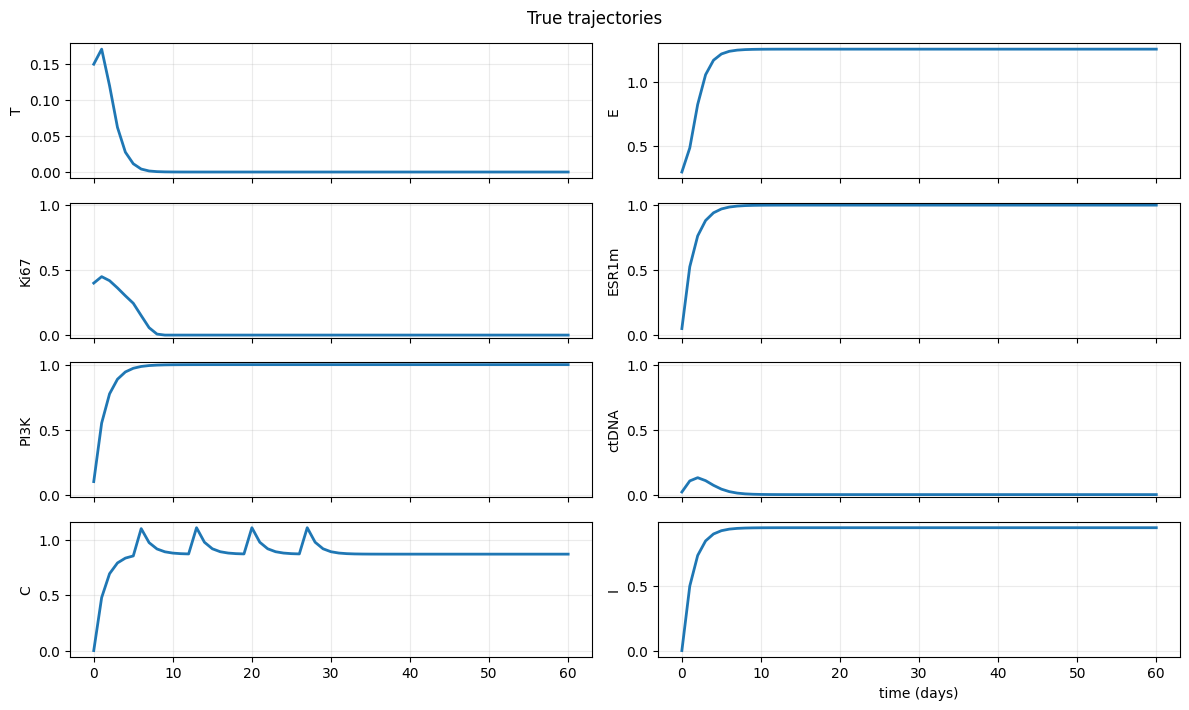

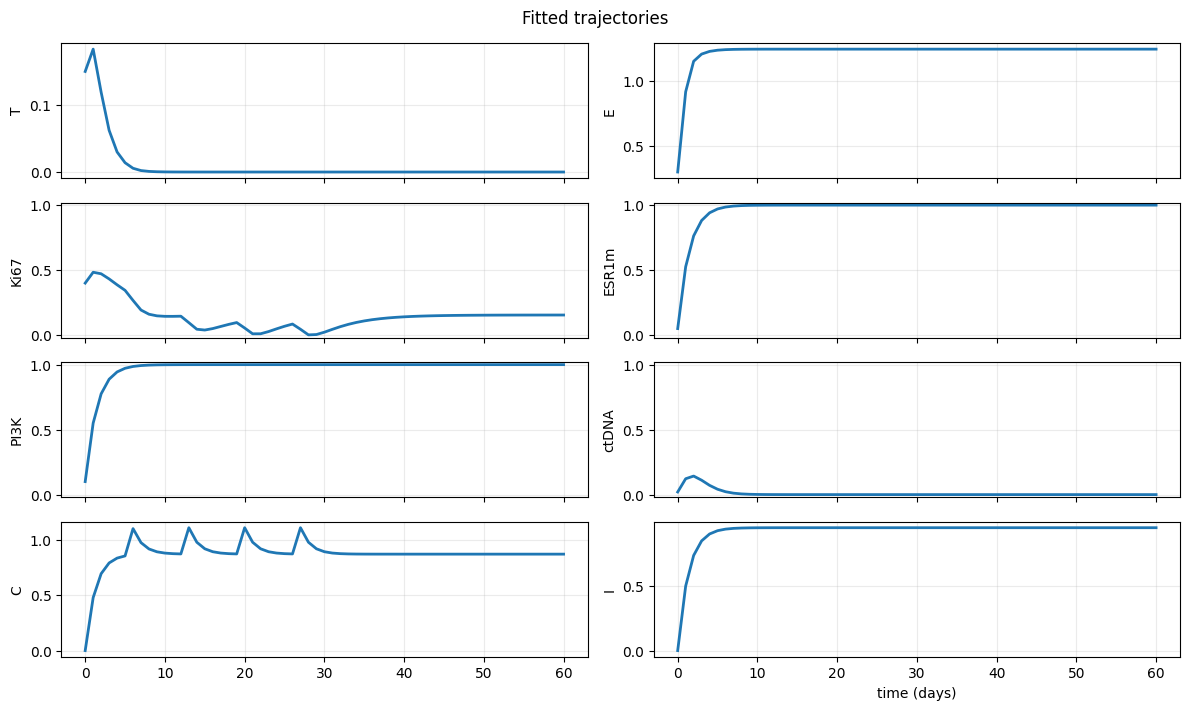

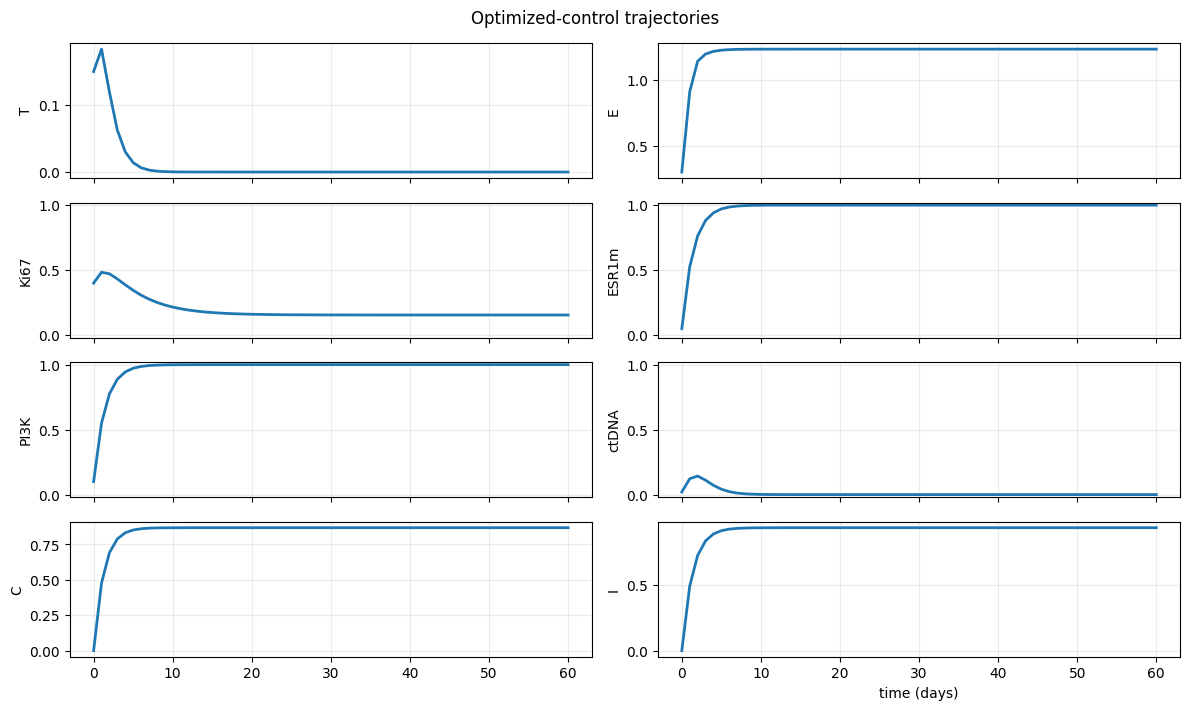

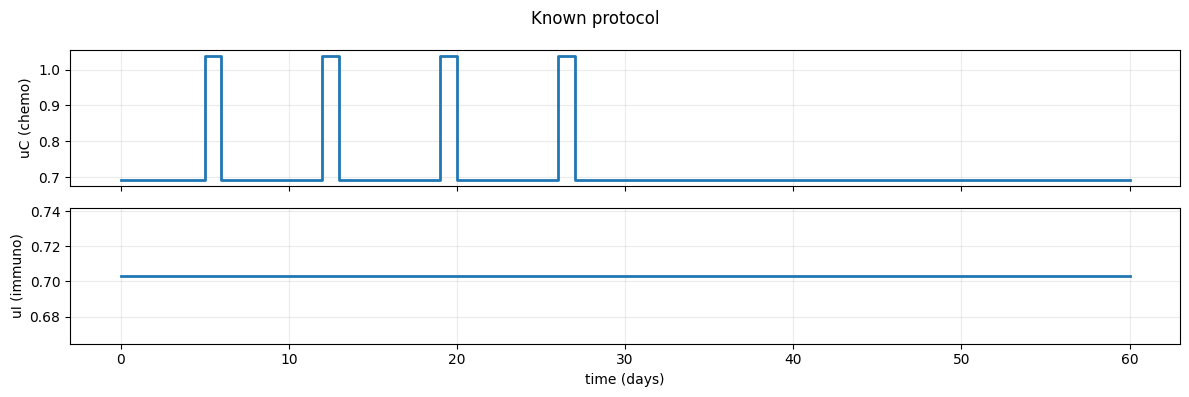

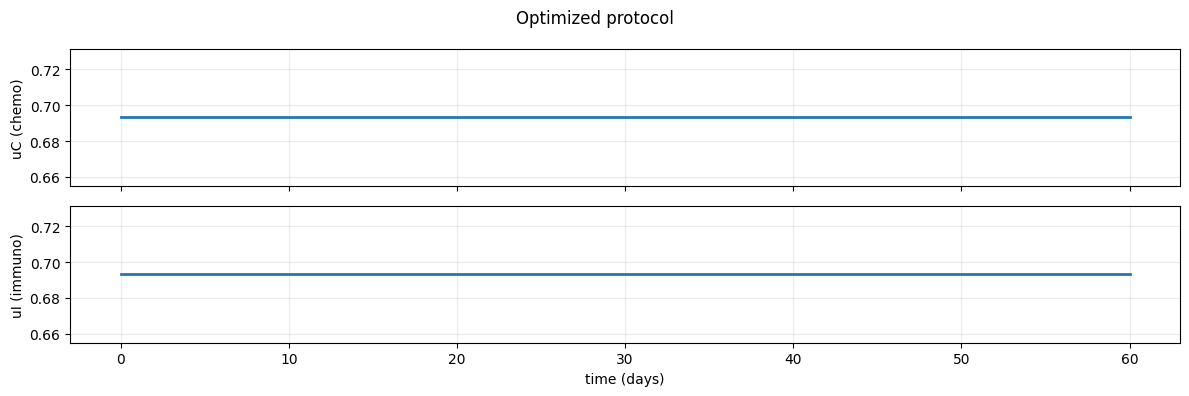

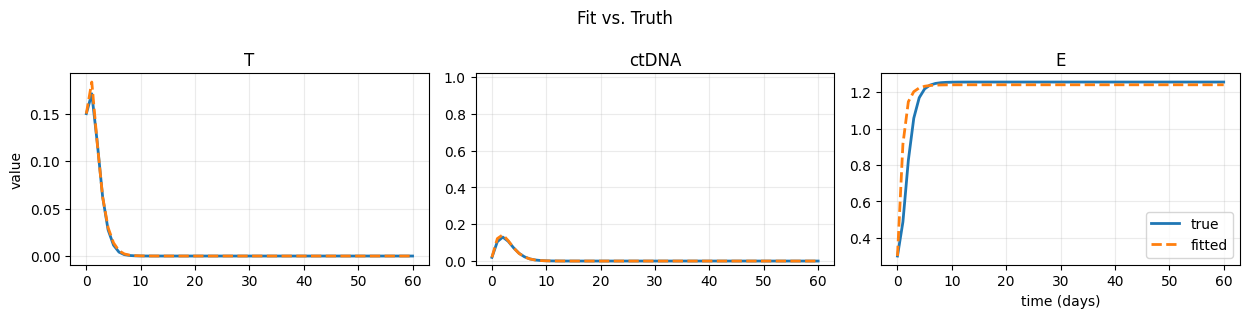

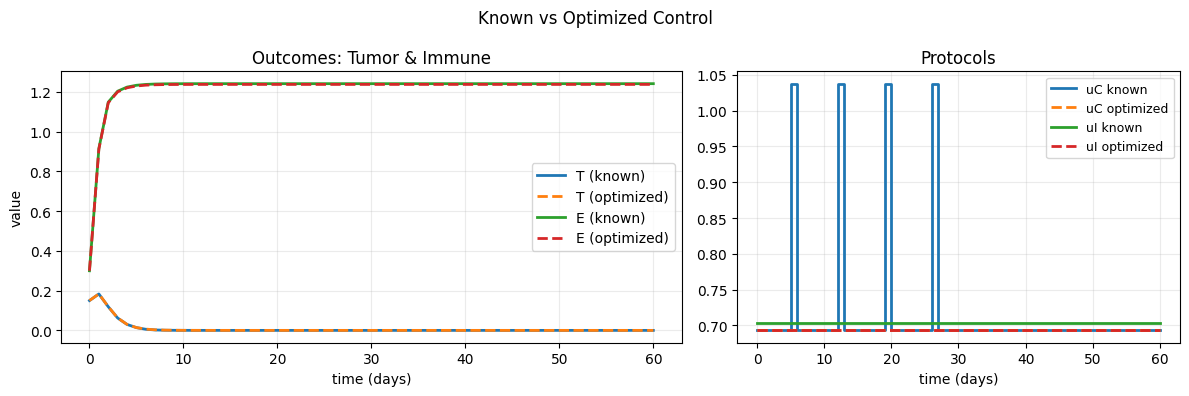

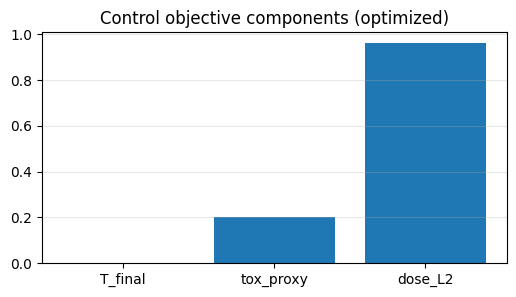

In [5]:
if __name__ == "__main__":
    # ... your existing code that creates true_traj, fit_traj, traj_opt, etc.

    # 1) Inspect the raw state evolution for each scenario
    plot_states_grid(tgrid, true_traj, title="True trajectories")
    plot_states_grid(tgrid, fit_traj,  title="Fitted trajectories")
    plot_states_grid(tgrid, traj_opt,  title="Optimized-control trajectories")

    # 2) Protocols (original vs optimized)
    plot_protocol(tgrid, known_protocol, title="Known protocol")
    plot_protocol(tgrid, dosing_opt,    title="Optimized protocol")

    # 3) Overlay of key observables (truth vs fit)
    overlay_fit_vs_true(tgrid, true_traj, fit_traj, keys=("T","ctDNA","E"))

    # 4) Compare outcomes under known vs optimized dosing
    compare_control_outcomes(tgrid, fit_traj, traj_opt, known_protocol, dosing_opt)

    # 5) Show objective components for the optimized run
    objective_breakdown(traj_opt, dosing_opt, title="Control objective components (optimized)")

    plt.show()
